In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

data = pd.read_csv("hf://datasets/abullard1/steam-reviews-constructiveness-binary-label-annotations-1.5k/steam_reviews_constructiveness_1.5k.csv")
print(data)

        id                            game  \
0        1                        Among Us   
1        2                        Among Us   
2        3                        Among Us   
3        4                        Among Us   
4        5                        Among Us   
...    ...                             ...   
1456  1457  Tom Clancy's Rainbow Six Siege   
1457  1458  Tom Clancy's Rainbow Six Siege   
1458  1459  Tom Clancy's Rainbow Six Siege   
1459  1460  Tom Clancy's Rainbow Six Siege   
1460  1461  Tom Clancy's Rainbow Six Siege   

                                                 review  \
0     This game can suck my balls before I play it a...   
1     Very fun little party game! Even better with f...   
2     if you're lonely don't bother but if you're no...   
3                                      fun and anoyying   
4                               when impostor is sus...   
...                                                 ...   
1456                     Good. Bee

In [ ]:
row = data.shape[0]
print(row)

1461


In [ ]:
data = data.drop(['id', 'game', 'votes_up', 'voted_up', 'author_playtime_at_review', 'votes_funny'], axis=1)
print(data.head())

                                              review  constructive
0  This game can suck my balls before I play it a...             0
1  Very fun little party game! Even better with f...             1
2  if you're lonely don't bother but if you're no...             0
3                                   fun and anoyying             0
4                            when impostor is sus...             0


In [ ]:
def casefolding(Review):
    Review = Review.lower()
    return Review
data['review'] = data['review'].apply(casefolding)
data.head(10)

,review,constructive
0,this game can suck my balls before i play it a...,0
1,very fun little party game! even better with f...,1
2,if you're lonely don't bother but if you're no...,0
3,fun and anoyying,0
4,when impostor is sus...,0
5,william warhurst gets stuck under the bed afte...,0
6,it is amazing and very addicting,0
7,kult att spela med ven,0
8,"yes, u know why",0
9,a very fun game as long as you have a group of...,1


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

!pip install contractions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix

lemmatizer = WordNetLemmatizer()
english_stopwords = set(stopwords.words('english'))
gaming_terms = {'fps', 'gg', 'lvl', 'noob', 'op', 'nerf', 'buff', 'ez', 'gitgud'}

def expand_contractions(text):
    return fix(text)

def handle_negations(text):
    return re.sub(r"\bnot\s+(\w+)", r"not_\1", text)

def remove_terms(text):
    return ' '.join([word for word in text.split() if word not in gaming_terms])

def replace_emoticons(text):
    emoticons = {
        ':)': 'happy',
        ':(': 'sad',
        ':-)': 'happy',
        ':-(': 'sad',
    }
    for emoticon, meaning in emoticons.items():
        text = text.replace(emoticon, meaning)
    return text

def lemmatize_review(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

def cleansing(review):
    review = review.strip().lower()
    review = expand_contractions(review)
    review = handle_negations(review)
    review = re.sub(r"http\S+|www\S+|https\S+", '', review)
    review = re.sub(r'[^\w\s]', '', review)
    review = re.sub(r'\d+', '', review)
    review = re.sub(r"\b[a-zA-Z]\b", "", review)
    review = re.sub('\s+', ' ', review)
    review = replace_emoticons(review)
    review = remove_terms(review)
    review = ' '.join([word for word in review.split() if word not in english_stopwords])
    review = lemmatize_review(review)

    return review

data['review'] = data['review'].apply(cleansing)

data.head(10)

,review,constructive
0,game suck ball play fact fucking payed,0
1,fun little party game even better friend canno...,1
2,lonely not_bother not_a fucking loser friend g...,0
3,fun anoyying,0
4,impostor sus,0
5,william warhurst get stuck bed murder entire f...,0
6,amazing addicting,0
7,kult att spela med ven,0
8,yes know,0
9,fun game long group least people preferably pe...,1


In [ ]:
pip install imbalanced-learn

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

X = data['review']
y = data['constructive']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=128)

tfidf_vectorizer = TfidfVectorizer(max_features=3000, ngram_range=(1, 2), min_df=15, max_df=0.9)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

smote = SMOTE(random_state=128)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_tfidf, y_train)

rf_model = RandomForestClassifier(n_estimators=200, random_state=128)
cv_scores = cross_val_score(rf_model, X_train_balanced, y_train_balanced, cv=5)
rf_model.fit(X_train_balanced, y_train_balanced)

y_pred = rf_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       197
           1       0.69      0.72      0.70        96

    accuracy                           0.80       293
   macro avg       0.78      0.78      0.78       293
weighted avg       0.80      0.80      0.80       293

Accuracy: 0.8020477815699659


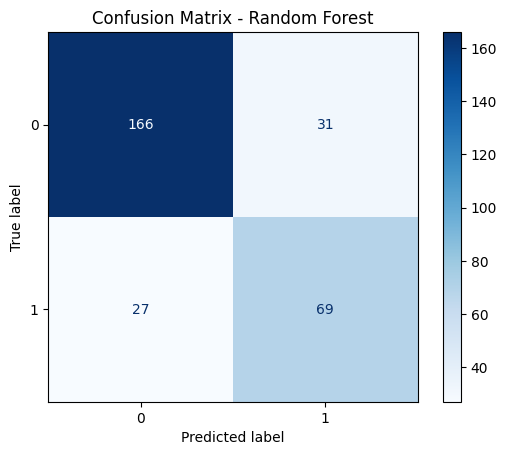

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)

disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.show()

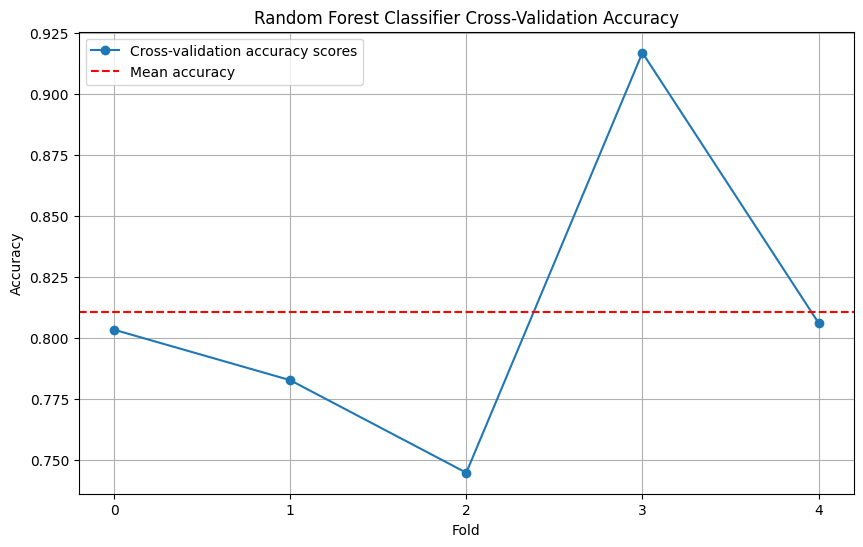

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cv_scores, marker='o', label='Cross-validation accuracy scores')
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label='Mean accuracy')
plt.title('Random Forest Classifier Cross-Validation Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(np.arange(len(cv_scores)))
plt.legend()
plt.grid()
plt.show()

In [ ]:
label_mapping = {0: 'Not Constructive', 1: 'Constructive'}
new_reviews = ["This game is really good, I love it so much!"]
new_reviews_clean = [cleansing(review) for review in new_reviews]
new_reviews_vectorized = tfidf_vectorizer.transform(new_reviews_clean).toarray()

predictions = rf_model.predict(new_reviews_vectorized)
predicted_labels = [label_mapping[pred] for pred in predictions]

for review, label in zip(new_reviews, predicted_labels):
    print(f"{review} = {label}")

This game is really good, I love it so much! = Constructive


Unlike other projects (somehow), the preprocessing is actually somehow the most influential part of making the analysis better. Especially by implementing gaming term as well as contractions. Apparently using CNN somehow made the model worse while I was configuring which learning model I should implement.

The model itself is at an 80% accuracy only due to dataset being imbalanced, that is also already being helped with using SMOTE that balances out the dataset by duplicating datas and make new underrepresented datas. The confusion matrix indicated that the non constructive (0) class is far better at being pred-true rather than the constructive class. It could be explained due to the double natured meaning of certain words, despite me already using bigrams.